# Two-Step Forecasting for weather and kWh delivered (using TCN)

In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model

In [2]:
pip install keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 8.9 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow-addons


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install --upgrade keras-tcn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import necessary packages

In [34]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, Input, Dense, Dropout, Flatten
from tcn import TCN, tcn_full_summary
from sklearn.model_selection import train_test_split

In [35]:
# Load the weather data from the weather data folder

In [37]:
folder_path = './caltech_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

weather_df = pd.DataFrame(data_frames)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.sort_values('date', inplace=True)

In [ ]:
# Select relevant features

In [43]:
weather_features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
weather_df = weather_df[weather_features + ['date']]

weather_daily_df.head()

,date,temperature,wind_speed,pressure,humidity,precip
0,2018-04-01,15.750,7.250,1012.250,55.250,0.0
1,2018-04-02,14.250,10.250,1010.500,65.750,0.0
2,2018-04-03,15.750,6.875,1014.125,64.875,0.0
3,2018-04-04,15.750,7.750,1016.125,65.625,0.0
4,2018-04-05,15.875,8.000,1015.750,62.125,0.0


In [3]:
# Aggregate weather data by day (since kWh data is monthly, daily aggregation should be sufficient)

In [18]:
weather_daily_df = weather_df.groupby('date').mean().reset_index()

In [ ]:
# Normalize the data and split into training and testing sets

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weather_daily_df[weather_features])

In [ ]:
# Create sequences for TCN

In [28]:
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

In [ ]:
# Split data into training and testing sets

In [49]:
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the TCN model

In [50]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),
    Conv1D(filters=64, kernel_size=2, dilation_rate=1, padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=2, dilation_rate=2, padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=2, dilation_rate=4, padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=2, dilation_rate=8, padding='causal', activation='relu'),
    Flatten(),
    Dropout(0.2),
    Dense(units=len(weather_features))
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
model.summary()

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0516
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 16/50
56/56 ━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 30, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         9,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,233 (411.07 KB)

 Trainable params: 35,077 (137.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 70,156 (274.05 KB)

In [ ]:
# Evaluate the model and check for accuracy

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Temperature - Mean Absolute Error: 1.974963775377595
Temperature - Mean Squared Error: 6.172395043098809
Wind_speed - Mean Absolute Error: 1.4997384027148901
Wind_speed - Mean Squared Error: 4.399835217899564
Pressure - Mean Absolute Error: 2.1515907544768265
Pressure - Mean Squared Error: 7.873258310690353
Humidity - Mean Absolute Error: 9.972385717241952
Humidity - Mean Squared Error: 171.26527948775433
Precip - Mean Absolute Error: 0.14815967911060082
Precip - Mean Squared Error: 0.08653699943312072


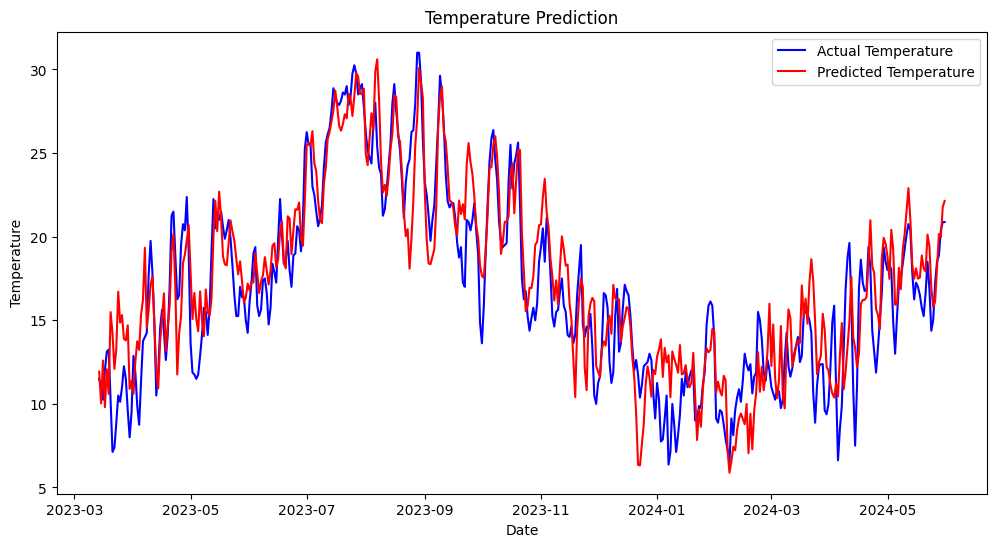

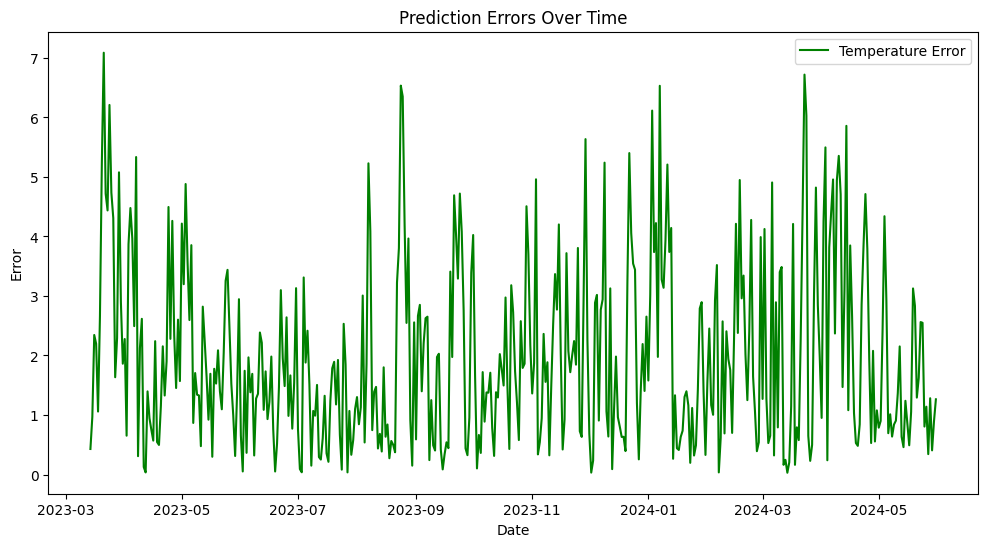

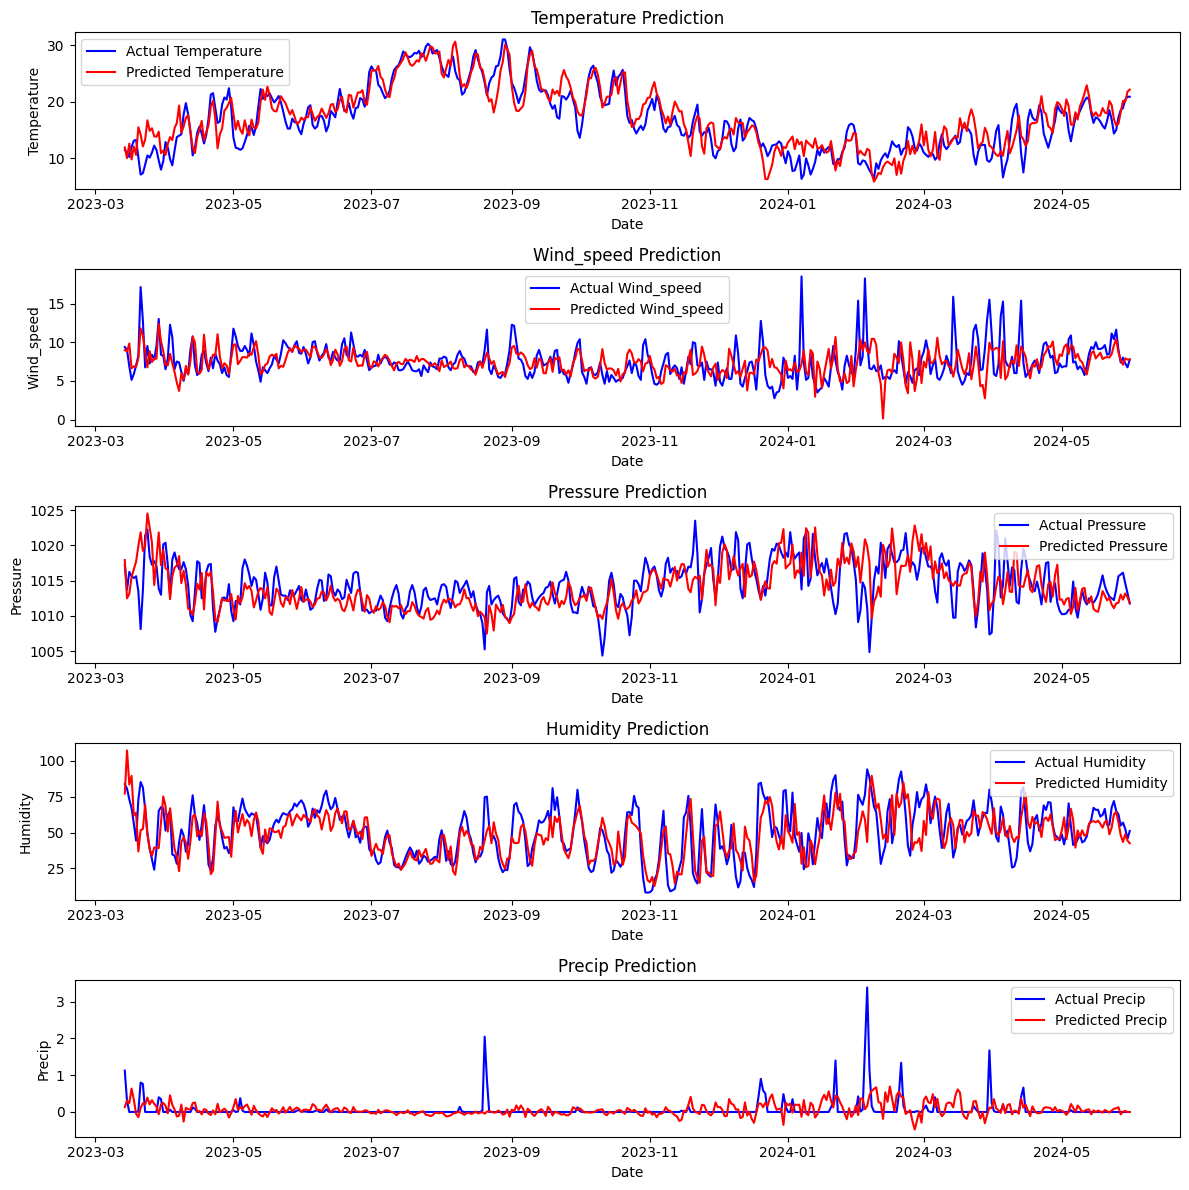

In [51]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the model for each feature
mae_per_feature = []
mse_per_feature = []

for i, feature in enumerate(weather_features):
    mae = mean_absolute_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mse = mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(weather_daily_df['date'][train_size+sequence_length:], y_test_inverse[:, 0], color='blue', label='Actual Temperature')
plt.plot(weather_daily_df['date'][train_size+sequence_length:], y_pred_inverse[:, 0], color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot the errors over time
errors = np.abs(y_test_inverse - y_pred_inverse)
plt.figure(figsize=(12, 6))
plt.plot(weather_daily_df['date'][train_size+sequence_length:], errors[:, 0], color='green', label='Temperature Error')
plt.title('Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(weather_features):
    plt.subplot(len(weather_features), 1, i+1)
    plt.plot(weather_daily_df['date'][train_size+sequence_length:], y_test_inverse[:, i], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(weather_daily_df['date'][train_size+sequence_length:], y_pred_inverse[:, i], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

# Second step

Using the forecasted weather data to predict future kWh delivered by electric vehicle charging stations

In [52]:
stations_folder_path = './caltech_stations_data'
stations_data_frames = []

for file_name in os.listdir(stations_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(stations_folder_path, file_name)
        try:
            station_df = pd.read_csv(file_path)
            stations_data_frames.append(station_df)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

ev_data = pd.concat(stations_data_frames, ignore_index=True)
ev_data['date'] = pd.to_datetime(ev_data['month'], format='%Y-%m')
ev_data.drop(columns=['month'], inplace=True)

# Merge the weather data with the EV charging station data
merged_df = pd.merge(ev_data, weather_daily_df, on='date', how='left')

# Fill missing values (if any) with forward fill method
merged_df.ffill(inplace=True)

In [ ]:
# Perform feature engineering

In [61]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[weather_features + ['kWhDelivered']])

# Create sequences for TCN
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, -1])  # kWhDelivered is the target variable

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the TCN model for kWh delivered prediction
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    Input(shape=input_shape),
    Conv1D(filters=64, kernel_size=2, dilation_rate=1, padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=2, dilation_rate=2, padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=2, dilation_rate=4, padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=2, dilation_rate=8, padding='causal', activation='relu'),
    Flatten(),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], len(weather_features))), y_test.reshape(-1, 1)), axis=1)
)[:, -1]
y_pred_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((y_pred.shape[0], len(weather_features))), y_pred), axis=1)
)[:, -1]

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0671  
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0298
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092
Epoch 16/30
18/18

In [ ]:
# Evaluate the model

Mean Absolute Error: 80.94391275074888
Mean Squared Error: 10769.586054638698


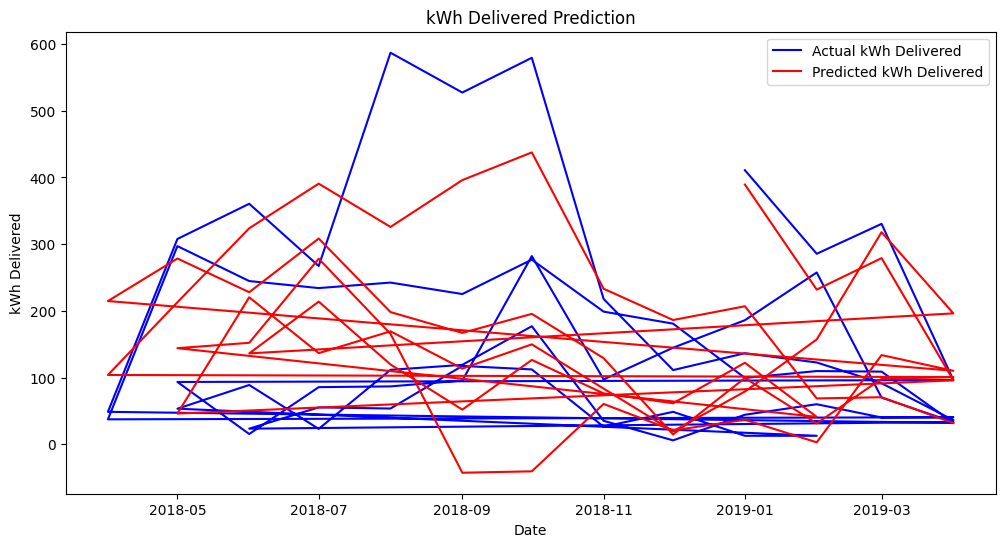

In [62]:
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'][train_size+sequence_length:], y_test_inverse, color='blue', label='Actual kWh Delivered')
plt.plot(merged_df['date'][train_size+sequence_length:], y_pred_inverse, color='red', label='Predicted kWh Delivered')
plt.title('kWh Delivered Prediction')
plt.xlabel('Date')
plt.ylabel('kWh Delivered')
plt.legend()
plt.show()